Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST.

Классификатор строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## 1. Импорт библиотек и данных

In [1]:
import numpy as np
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [20]:
train.shape

(42000, 785)

In [21]:
test.shape

(28000, 784)

In [22]:
train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [23]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# сохраняем метки в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду - 28 на 28
train_img = np.reshape(train[:, 1:], (len(train[:, 1:]), 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [25]:
print(train_img.shape)
print(test_img.shape)

(42000, 28, 28)
(28000, 28, 28)


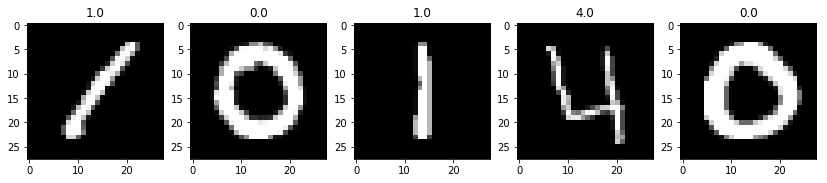

In [26]:
# визуализируем первые 5 объектов из train
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], start=1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

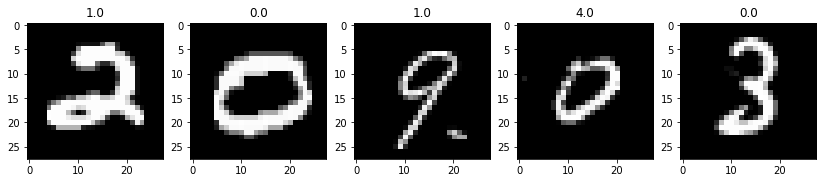

In [27]:
# визуализируем первые 5 объектов из test

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], start=1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Классификация на основе PCA-преобразования

In [64]:
# выбираем семпл данных для обработки
choices = np.random.choice(train_img.shape[0], 10000)

y = train_label[choices]
X = train_img[choices].reshape(-1, 28 * 28).astype(np.float32)

In [65]:
print(y.shape)
print(X.shape)
print(train_label.shape)
print(train_img.shape)

(10000,)
(10000, 784)
(42000,)
(42000, 28, 28)


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


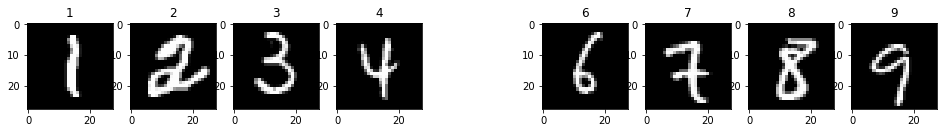

In [66]:
fig = plt.figure(figsize=(20, 10))
for i, img in zip(y[:30], X.reshape(10000, 28, 28)[:30]):
    try:
        subplot = fig.add_subplot(1, 11, i)
        plt.imshow(img, cmap='gray');
        subplot.set_title('%s' % int(i))
    except:
        continue;

In [67]:
# делим на трейн и тест до шкалирования
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42)

In [68]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(8000, 784)
(8000,)
(2000, 784)
(2000,)


In [69]:
# шкалируем данные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [70]:
X_train = scaler.fit_transform(X_train)

In [71]:
X_train.shape

(8000, 784)

In [72]:
X_test = scaler.fit_transform(X_test)

In [73]:
X_test.shape

(2000, 784)

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


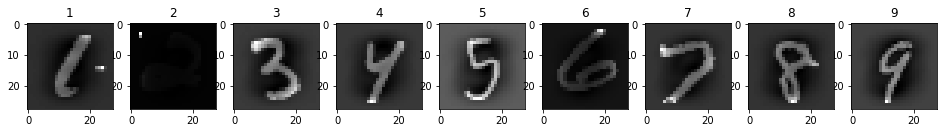

In [74]:
# смотрим, как выглядят нормированные признаки
fig = plt.figure(figsize=(20, 10))
for i, img in zip(y_train[:30], X_train.reshape(8000, 28, 28)[:30]):
    try:
        subplot = fig.add_subplot(1, 11, i)
        plt.imshow(img, cmap='gray');
        subplot.set_title('%s' % int(i))
    except:
        continue;

In [75]:
# корреляции имеет меньшая часть пикселей в наших квадратах
corr_ = np.dot(X_train.T, X_train)/ X_train.shape[0] # матрица ковариации признаков
pd.DataFrame(corr_).corr()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


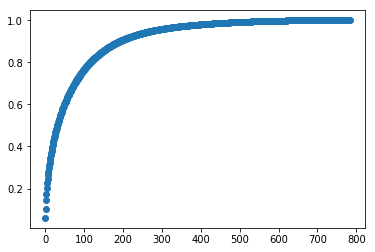

In [78]:
# считаем накопленную сумму собственных значений
U, S, _ = np.linalg.svd(corr_)
# U - собственные вектора матрицы ковариации
# S - собственные значения

S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [79]:
# смотрим на изменение кумулятивной суммы
for i in range(15):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[000] 0.060
[001] 0.104
[002] 0.144
[003] 0.174
[004] 0.201
[005] 0.225
[006] 0.246
[007] 0.264
[008] 0.281
[009] 0.296
[010] 0.311
[011] 0.324
[012] 0.336
[013] 0.347
[014] 0.359


In [80]:
S_thr = 0.75  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=94 S=0.752


In [81]:
# понижаем размерность
from sklearn.decomposition import PCA

In [83]:
# проверим себя с помощью готового метода:
# n-components=94, explained variance 0.750
pca = PCA(n_components=X_train.shape[1]).fit(X_train)
for i in range(1, X_train.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.060
n-components=2, explained variance 0.104
n-components=3, explained variance 0.144
n-components=4, explained variance 0.174
n-components=5, explained variance 0.201
n-components=6, explained variance 0.225
n-components=7, explained variance 0.246
n-components=8, explained variance 0.264
n-components=9, explained variance 0.281
n-components=10, explained variance 0.296
n-components=11, explained variance 0.311
n-components=12, explained variance 0.324
n-components=13, explained variance 0.336
n-components=14, explained variance 0.347
n-components=15, explained variance 0.359
n-components=16, explained variance 0.369
n-components=17, explained variance 0.380
n-components=18, explained variance 0.390
n-components=19, explained variance 0.400
n-components=20, explained variance 0.409
n-components=21, explained variance 0.418
n-components=22, explained variance 0.427
n-components=23, explained variance 0.436
n-components=24, explained variance 0.444
n

In [85]:
pca = PCA(n_components=94, whiten=True, random_state=42).fit(X_train)

In [86]:
# оставляем только 94 самые значимые фичи
X_train_reduced = pca.transform(X_train)

In [87]:
X_train_reduced.shape

(8000, 94)

In [119]:
# можно обучить классификатор на 94 фичах

In [88]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train_reduced, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [90]:
X_test_reduced = pca.transform(X_test)

In [91]:
print(X_test_reduced.shape)


(2000, 94)


In [92]:
tree_prediction = clf.predict(X_test_reduced)

In [93]:
tree_prediction[:10]

array([0., 5., 9., 1., 1., 9., 1., 5., 1., 7.])

In [94]:
y_test[:10]

array([0., 5., 9., 1., 1., 5., 1., 5., 1., 7.])

In [95]:
## Оцениваем качество решения на валидационной выборке
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, tree_prediction))

Accuracy: 0.7715


In [96]:
from sklearn.metrics import classification_report # для каждого класса показывает метрики
# support - количество примеров класса в датасете
# Precision можно интерпретировать как долю объектов, 
# названных классификатором положительными и при этом действительно являющимися положительными
# recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм
# f1-score - среднее гармоническое precision и recall
print(classification_report(y_test, tree_prediction))

              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       191
         1.0       0.91      0.90      0.91       217
         2.0       0.76      0.75      0.76       207
         3.0       0.71      0.75      0.73       189
         4.0       0.78      0.80      0.79       195
         5.0       0.73      0.63      0.68       195
         6.0       0.82      0.85      0.83       194
         7.0       0.86      0.79      0.82       228
         8.0       0.69      0.62      0.66       202
         9.0       0.66      0.76      0.71       182

   micro avg       0.77      0.77      0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



In [130]:
# можно сказать, что результат неплохой: взяли в 8 раз меньше признаков и получили неплохое качество предсказаний

In [99]:
# теперь проверим на большом тесте

X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)

In [101]:
X_test = scaler.fit_transform(X_test)

In [102]:
# оставляем только 94 самые значимые фичи
X_test_reduced = pca.transform(X_test)

In [103]:
X_test_reduced.shape

(28000, 94)

In [104]:
tree_prediction_for_kaggle_1 = np.array(clf.predict(X_test_reduced), dtype='int')

In [106]:
tree_prediction_for_kaggle_1

array([2, 0, 9, ..., 3, 9, 8])

In [107]:
tree_prediction_for_kaggle_1.shape

(28000,)

In [105]:
## Готовим файл для отправки
with open('submit_1.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(tree_prediction_for_kaggle_1, 1):
        dst.write('%s,%s\n' % (i, p))

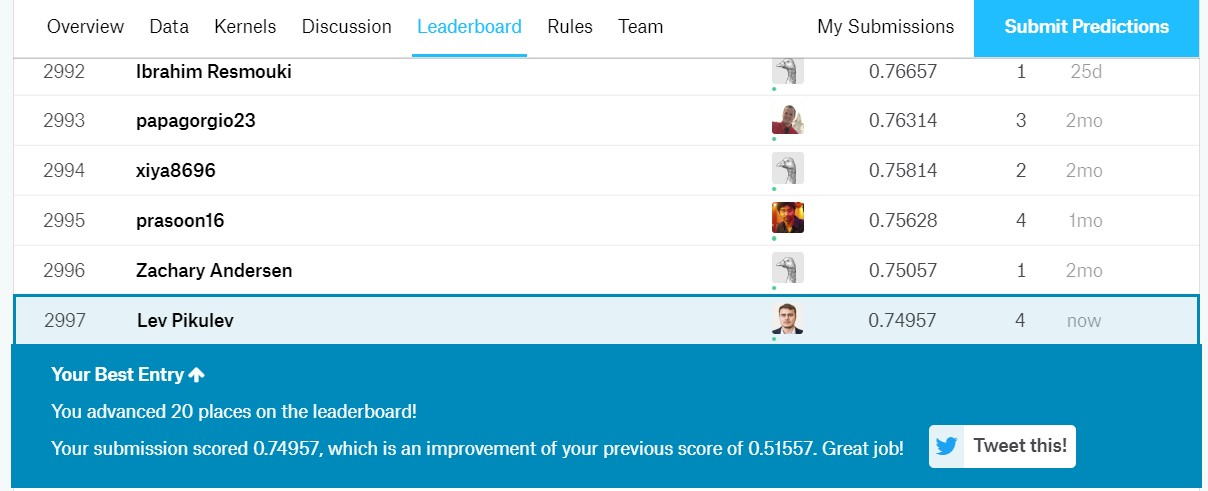

In [108]:
# результат на Kaggle - accuracy = 0.749
from IPython.display import Image
Image("Screenshot_2.jpg", width=500, height=300)

## Классификация на основе гистограмм градиентов HOG

In [109]:
## Вычисляем X и Y составляющие градиента с помощью оператора Собеля
train_sobel_x = np.zeros_like(train_img) # вычисляем для каждого изображения гистограмму градиента с помощью оператора Собеля
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [110]:
test_sobel_x = np.zeros_like(test_img) # то же самое и для теста
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [111]:
print(train_sobel_x.shape)
print(train_sobel_y.shape)
print(test_sobel_x.shape)
print(test_sobel_x.shape)

(42000, 28, 28)
(42000, 28, 28)
(28000, 28, 28)
(28000, 28, 28)


In [112]:
## Вычисляем угол и длину вектора градиента
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y) #cartToPolar - перевод в полярные координаты
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

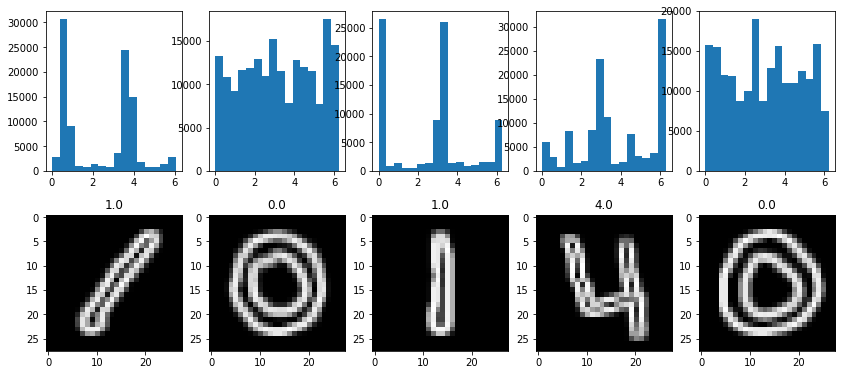

In [113]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(), #flatten() - Return a copy of the array collapsed into one dimension.
             bins=16, weights=train_g[i - 1].flatten())

In [114]:
## Вычисляем гистограммы градиентов
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 32))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=32,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [115]:
test_hist = np.zeros((len(test_img), 32))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=32,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [116]:
## Нормируем вектор гистограммы
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [117]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [118]:
train_hist.shape

(42000, 32)

In [119]:
test_hist.shape

(28000, 32)

In [120]:
train_label.shape

(42000,)

In [124]:
# разобъем test_hist на тренировочную и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(
    train_hist, train_label, test_size=0.2,
    random_state=42)

In [125]:
clf_2 = DecisionTreeClassifier()
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [126]:
prediction = np.array(clf_2.predict(X_test), dtype='int')

In [127]:
## Оцениваем качество решения на валидационной выборке. Качество низкое
print('Accuracy: %s' % accuracy_score(y_test, prediction))

Accuracy: 0.44976190476190475


In [128]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.26      0.27      0.26       816
         1.0       0.91      0.91      0.91       909
         2.0       0.27      0.29      0.28       846
         3.0       0.46      0.40      0.43       937
         4.0       0.49      0.48      0.49       839
         5.0       0.44      0.46      0.45       702
         6.0       0.25      0.27      0.26       785
         7.0       0.63      0.62      0.63       893
         8.0       0.33      0.32      0.33       835
         9.0       0.44      0.41      0.42       838

   micro avg       0.45      0.45      0.45      8400
   macro avg       0.45      0.44      0.45      8400
weighted avg       0.45      0.45      0.45      8400



In [129]:
# используем GridSearchCV для поиска лучших параметров
from sklearn.model_selection import GridSearchCV

In [170]:
# попробуем оценить эфективность при разных глубинах деревьев от 1 до 10 и 
# минимальном кол-ве фичей от 1 до 5, которые следует учитывать при поиске наилучшего разделения
depths = np.arange(1,10)
min_samples_leaves = np.arange(1,5)
grid = {'max_depth': depths, 'min_samples_leaf': min_samples_leaves}
gridsearch_2 = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)
# говорим возьми DecisionTreeClassifier и для словаря grid (в котором два ключа max_depth и min_samples_leaves) 
# комбинаторно перебери 10 и 4 значений соответственно
# отсортируй их по neg_log_loss (scoring='neg_log_loss') на пятикратную кросс-валидацию

In [171]:
%%time
gridsearch_2.fit(X_train, y_train) # фитим

Wall time: 2min 1s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [183]:
sorted(zip(gridsearch_2.cv_results_['mean_test_score'], gridsearch_2.cv_results_['params']), key = lambda x: x[0])

[(-2.708059147573455, {'max_depth': 9, 'min_samples_leaf': 2}),
 (-2.693416988156762, {'max_depth': 9, 'min_samples_leaf': 1}),
 (-2.6699693565064098, {'max_depth': 9, 'min_samples_leaf': 3}),
 (-2.6509371902043495, {'max_depth': 9, 'min_samples_leaf': 4}),
 (-2.139853283939002, {'max_depth': 8, 'min_samples_leaf': 2}),
 (-2.137108358741501, {'max_depth': 8, 'min_samples_leaf': 1}),
 (-2.127365787356647, {'max_depth': 8, 'min_samples_leaf': 3}),
 (-2.1176593124395198, {'max_depth': 8, 'min_samples_leaf': 4}),
 (-2.1070721653412394, {'max_depth': 1, 'min_samples_leaf': 1}),
 (-2.1070721653412394, {'max_depth': 1, 'min_samples_leaf': 2}),
 (-2.1070721653412394, {'max_depth': 1, 'min_samples_leaf': 3}),
 (-2.1070721653412394, {'max_depth': 1, 'min_samples_leaf': 4}),
 (-1.9631526263123296, {'max_depth': 2, 'min_samples_leaf': 1}),
 (-1.9631526263123296, {'max_depth': 2, 'min_samples_leaf': 2}),
 (-1.9631526263123296, {'max_depth': 2, 'min_samples_leaf': 3}),
 (-1.9631526263123296, {'max_d

In [189]:
# обучаем лес с отобранными параметрами

clf_2 = DecisionTreeClassifier(max_depth= 9, min_samples_leaf=2)


clf_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [190]:
prediction = np.array(clf_2.predict(X_test), dtype='int')

In [191]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, prediction))

[[212   7  49  49  49  26 111  10 202 101]
 [  5 813   1   0  55   1   7  11   1  15]
 [ 46   0 226 146  22 130  99  25  95  57]
 [ 34   0 137 433  12 119  37   4 120  41]
 [ 39  33  18  13 437   3 101  53  16 126]
 [ 16   0 107 150   6 330  26   8  45  14]
 [140   4  55  25  75  22 216  10 100 138]
 [ 19   3  31  11 133  31  62 487  13 103]
 [130   1  71  39  24  35  63   7 394  71]
 [ 75   5  38  23  88  18 102  14  66 409]]


In [192]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.30      0.26      0.28       816
         1.0       0.94      0.89      0.92       909
         2.0       0.31      0.27      0.29       846
         3.0       0.49      0.46      0.47       937
         4.0       0.49      0.52      0.50       839
         5.0       0.46      0.47      0.47       702
         6.0       0.26      0.28      0.27       785
         7.0       0.77      0.55      0.64       893
         8.0       0.37      0.47      0.42       835
         9.0       0.38      0.49      0.43       838

   micro avg       0.47      0.47      0.47      8400
   macro avg       0.48      0.47      0.47      8400
weighted avg       0.48      0.47      0.47      8400



In [193]:
# точность конечно улучшилась, но не до 0,6
print('Accuracy: %s' % accuracy_score(y_test, prediction))

Accuracy: 0.4710714285714286


In [194]:
# делаем предсказание для большой тестовой выборки
tree_prediction_for_kaggle_2 = np.array(clf_2.predict(test_hist), dtype='int')

In [195]:
## Готовим файл для отправки
with open('submit_2.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(tree_prediction_for_kaggle_2, 1):
        dst.write('%s,%s\n' % (i, p))

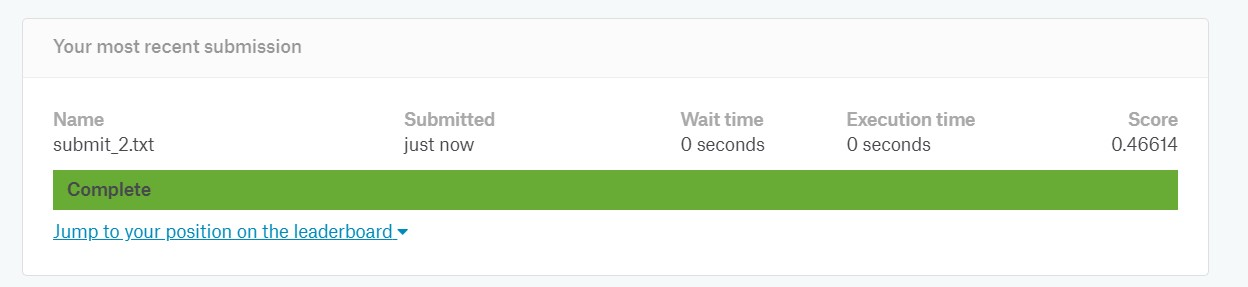

In [196]:
# результат на Kaggle - accuracy = 0.466 не впечатляет
from IPython.display import Image
Image("Screenshot_3.jpg", width=500, height=300)